In [454]:
#!conda install -y -c conda-forge pyarrow

In [455]:
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
import dask.dataframe as dd
import pandas as pd
import re
import os

%matplotlib inline
%config Completer.use_jedi = False
pd.options.mode.chained_assignment = None

In [456]:
xid_names = {
    31: 'Memory page fault', 13: 'Graphics engine exception', 43: 'Stopped processing', 74: 'NVLINK error',
    63: 'Page retirement event', 64: 'Page retirement failure', 48: 'Double-bit error', 45: 'Preemptive cleanup',
    61: 'Internal microcontroller warning', 44: 'Graphics engine fault', 79: 'Fallen off the bus', 62: 'Internal microcontroller halt',
    38: 'Driver firmware error', 32: 'Corrupted push buffer stream', 12: 'Driver error handling exception', 69: 'Graphics engine class error'}


**Set parameters**

In [457]:
plt.rcParams["axes.labelweight"] = "bold"

sns.set_palette("deep")
sns.set_style("white")
sns.set_context("paper", font_scale = 2.0, rc={"grid.linewidth": 2.5, 'fontweight':'bold'})

plt.style.use("acm_ieee_latex_pubstyle.txt")

SINGLE_COLUMN = SINGLE_WIDTH = 8.0
DOUBLE_COLUMN = DOUBLE_WIDTH = 16.0

def width_height(width=SINGLE_COLUMN, height=None, columns=1, rows=1):
    if height is None:
        height = width * 3/4
    ratio = float(width) / (float(height) / float(rows))
    return {"height": (float(width) / ratio), "aspect": ratio / float(columns)}

**Load GPU failures**

In [501]:
XID = 'xid'
Z = 'z_score'
XID_NAME = 'type'
df = pd.read_csv(
    '/gpfs/alpine/stf218/proj-shared/data/lake/summit_gpu_failures/gpu_failures_zscores_ref218.csv',
    parse_dates=['timestamp', 'exact'])
df[XID_NAME] = df[XID].apply(xid_names.get)
(~df[Z].isna()).sum(), df['processed'].sum()

(93229, 238519)

In [502]:
(~df['temp'].isna()).sum(), df['processed'].sum()

(126890, 238519)

In [503]:
df[~df[Z].isna()][XID].value_counts()

31    77500
13     7981
43     7020
63      376
64       90
74       67
48       57
45       56
44       33
61       18
12        9
62        7
79        6
32        6
38        3
Name: xid, dtype: int64

In [505]:
xid_counts = df.groupby(XID)[XID].count()
xids = xid_counts[xid_counts >= 30].index.values
df = df[df[XID].isin(xids)].copy()

**Plot distributions of GPU core temperature z-score**

In [506]:
df_plot = df[~df[Z].isna() & (df['hostname'] != 'f26n07')] 
xid_order = df_plot[XID].value_counts().sort_values(ascending=False).index.map(xid_names.get)

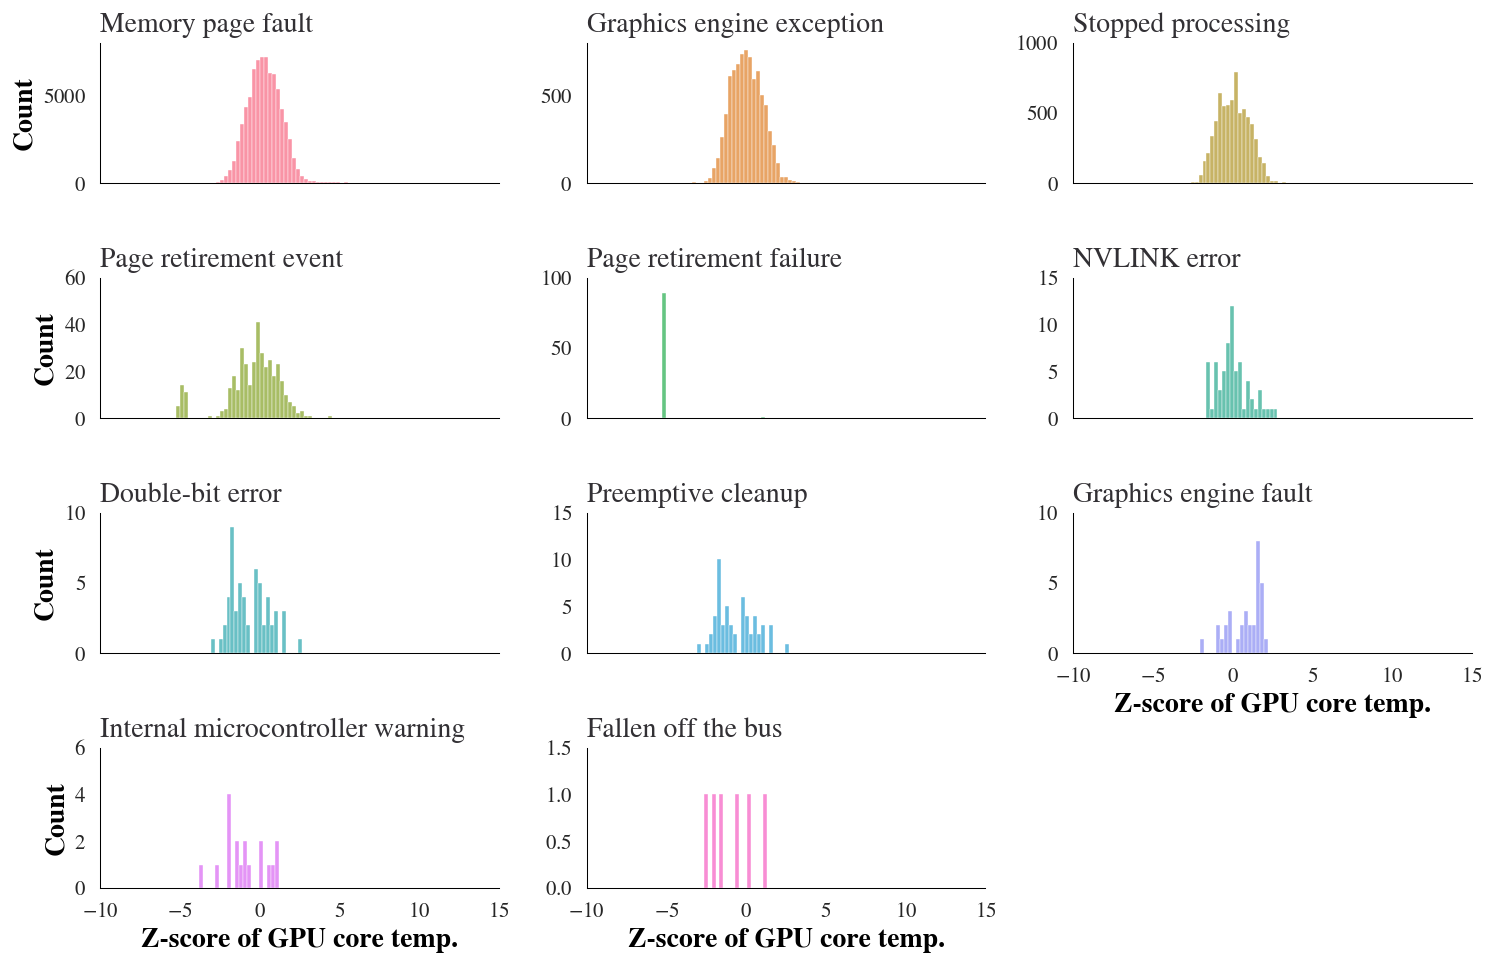

In [507]:
# Plot each distribution on individual facet.
g = sns.FacetGrid(df_plot, col=XID_NAME, hue=XID_NAME, hue_order=xid_order, col_order=xid_order,
                  col_wrap=3, sharey=False, **width_height(columns=2, rows=3))
g.map(sns.histplot, Z, binwidth=.25)
g.set_axis_labels('Z-score of GPU core temp.', 'Count')
g.set_titles('{col_name}')
g.savefig('../plots/failure_temp_Z_dist_facet.pdf')

In [508]:
xid_order = [x for x in xid_order if x not in ['Preemptive cleanup', 'Memory page fault', 'Stopped processing', 'Graphics engine exception']]
df_plot = df_plot[df_plot[XID_NAME].isin(xid_order)]

/ccs/home/olesv/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


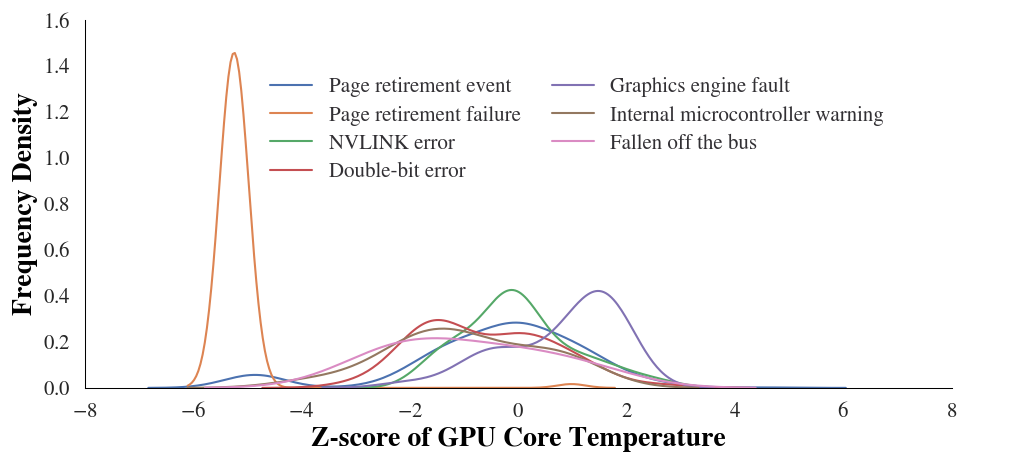

In [510]:
# Superimpose all distributions on one plot.
g = sns.FacetGrid(df_plot, hue=XID_NAME, hue_order=xid_order, **width_height(height=4))
g.map(sns.kdeplot, Z, common_norm=False)
g.set_axis_labels('Z-score of GPU Core Temperature', "Frequency Density")
g.add_legend(title='', labels=xid_order, loc=(.26, .6), ncol=2, fontsize=12) #'upper center'
g.savefig('../plots/failure_temp_Z_dist_combined.pdf')

In [513]:
g.fig.get_size_inches()

array([12.975,  4.   ])

**Plot distributions of GPU core temperature**

In [514]:
bad_idxs = [140776, 140771] # NVLINK errors at high temperatures that are not visible but skew the x-axis 
df_plot = df[~df[TEMP].isna()  & (df['hostname'] != 'f26n07')] 

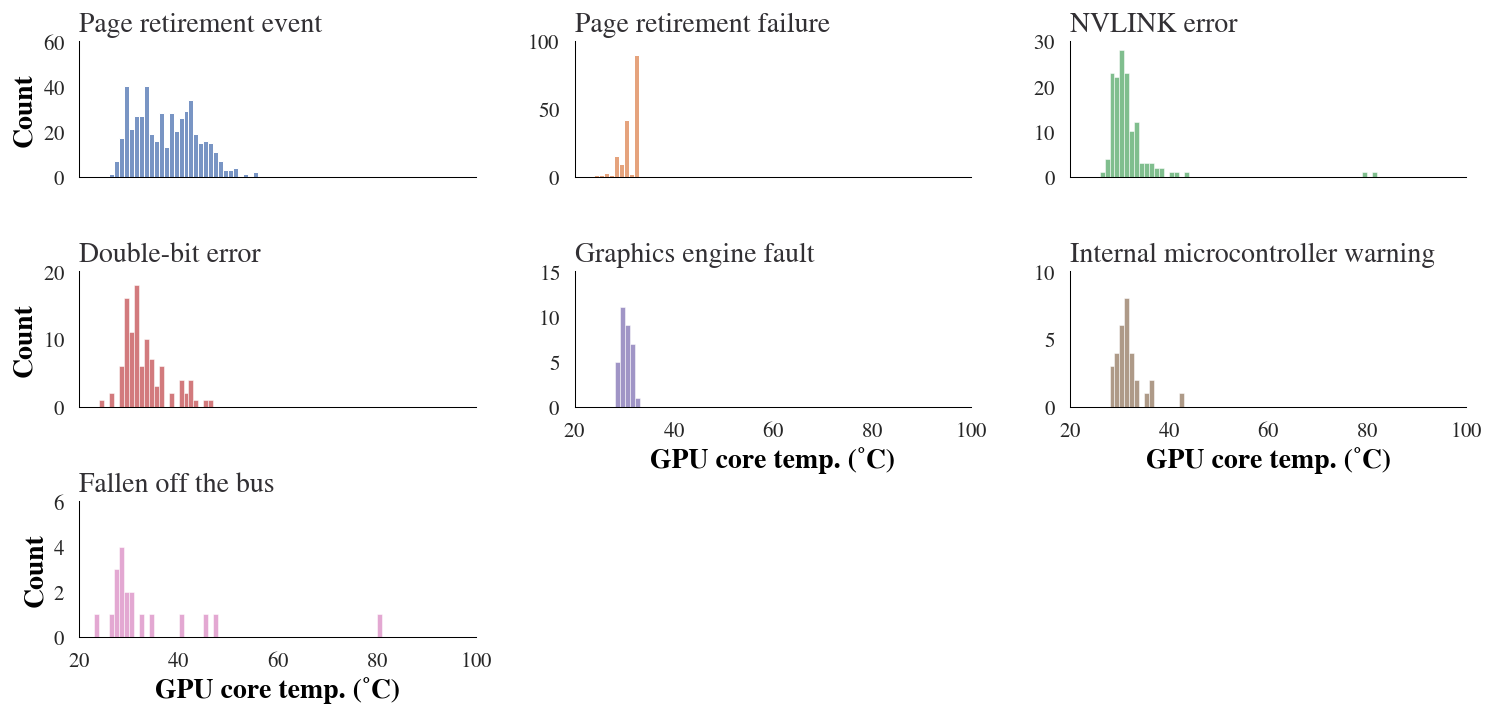

In [515]:
# Plot each distribution on individual facet.
g = sns.FacetGrid(df_plot, col=XID_NAME, hue=XID_NAME, hue_order=xid_order, col_order=xid_order,
                  col_wrap=3, sharey=False, **width_height(columns=2, rows=3))
g.map(sns.histplot, TEMP, binwidth=1)
g.set_axis_labels('GPU core temp. (˚C)', 'Count')
g.set_titles('{col_name}')
g.savefig('../plots/failure_temp_dist_facet.pdf')

In [516]:
xid_order = [x for x in xid_order if x not in ['Preemptive cleanup', 'Memory page fault', 'Stopped processing', 'Graphics engine exception']]
df_plot = df_plot[df_plot[XID_NAME].isin(xid_order)]

/ccs/home/olesv/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:132: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self.fig.legend(handles, labels, **kwargs)


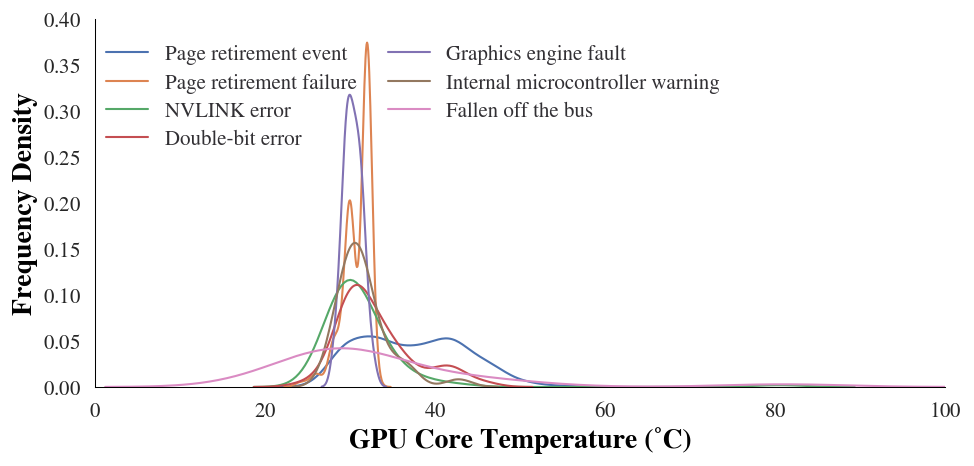

In [517]:
# Superimpose all distributions on one plot.
g = sns.FacetGrid(df_plot, hue=XID_NAME, hue_order=xid_order, **width_height(height=4))
g.map(sns.kdeplot, TEMP, common_norm=False)
g.set_axis_labels('GPU Core Temperature (˚C)', "Frequency Density")
g.add_legend(title='', labels=xid_order, loc=(.105, .67), ncol=2, fontsize=12) #'upper center'
g.axes[0][0].set_xlim(0, 100)
g.savefig('../plots/failure_temp_dist_combined.pdf')

In [387]:
df[df[XID] == 74].groupby(['hostname'])['hostname'].count().sort_values(), df[df[XID]==74].groupby(XID)[XID].count()
8462/8729

0.96941230381487

In [421]:
df[df[TEMP] > 60]

,orig_idx,timestamp,hostname,xid,GPU,exact,temp,z_score,mean,std,processed,type
93888,144294,2020-05-07 20:34:50+00:00,a03n13,31,3,2020-05-07 20:34:52+00:00,63.0,NaN,40.925343,3.32667,1,Memory page fault
97742,140776,2020-05-14 20:47:40+00:00,g15n02,74,1,2020-05-14 20:47:45+00:00,82.0,NaN,NaN,NaN,1,NVLINK error
97746,140772,2020-05-14 21:15:00+00:00,g15n02,79,2,2020-05-14 21:14:59+00:00,81.0,NaN,NaN,NaN,1,Fallen off the bus
97747,140771,2020-05-14 21:15:00+00:00,g15n02,74,0,2020-05-14 21:14:59+00:00,79.0,NaN,NaN,NaN,1,NVLINK error


In [441]:
df_plot[df_plot[XID] == 48][TEMP].max()

46.11111068725586